# Sceptic Basic Usage Example

This notebook demonstrates the basic workflow for using Sceptic to perform pseudotime analysis on single-cell data.

## Overview

Sceptic performs pseudotime estimation using supervised learning with nested cross-validation:
1. Takes a cell-by-feature matrix and time labels
2. Trains a classifier (SVM or XGBoost) to learn the relationship between features and time
3. Outputs: confusion matrix, predicted labels, continuous pseudotime, and class probabilities

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sceptic import run_sceptic_and_evaluate

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Example Data

We'll use the scGEM dataset, which contains single-cell gene expression data from a developmental time course.

In [2]:
# Load expression matrix (cells × genes)
data_concat = np.loadtxt("../example_data/scGEM/expression.txt")

# Load time labels
y = np.loadtxt("../example_data/scGEM/expression_type.txt")

print(f"Data shape: {data_concat.shape}")
print(f"Number of cells: {data_concat.shape[0]}")
print(f"Number of features: {data_concat.shape[1]}")
print(f"Encoded time points: {np.unique(y)}")

Data shape: (177, 34)
Number of cells: 177
Number of features: 34
Encoded time points: [0. 1. 2. 3. 4.]


## 3. Prepare Labels

Convert time labels to categorical values and map them to actual biological time points (hours).

The scGEM dataset has 5 developmental stages corresponding to:
- 0 → 0 hours
- 1 → 8 hours
- 2 → 16 hours
- 3 → 24 hours
- 4 → 30 hours

In [3]:
# Convert labels to categorical values
lab = preprocessing.LabelEncoder()
label = lab.fit_transform(y)

# Map encoded labels to actual biological time points (hours)
time_dictionary = {0.0: 0, 1.0: 8, 2.0: 16, 3.0: 24, 4.0: 30}
label_list = pd.Series(np.unique(label)).map(time_dictionary).to_numpy()

print(f"Encoded labels (first 10): {label[:10]}")
print(f"Actual time points (hours): {label_list}")

Encoded labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Actual time points (hours): [ 0  8 16 24 30]


## 4. Run Sceptic with SVM

First, let's try the SVM implementation.

In [4]:
# Define parameter grid for SVM
parameters_svm = {
    "C": [1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale"]
}

# Run Sceptic with SVM
print("Running Sceptic with SVM...")
cm_svm, label_predicted_svm, pseudotime_svm, sceptic_prob_svm = run_sceptic_and_evaluate(
    data=data_concat,
    labels=label,
    label_list=label_list,
    parameters=parameters_svm,
    method="svm"
)

print("\nSVM Results:")
print("Confusion Matrix:")
print(cm_svm)
print(f"\nAccuracy: {np.sum(np.diag(cm_svm)) / np.sum(cm_svm):.3f}")

Running Sceptic with SVM...

SVM Results:
Confusion Matrix:
[[35.  0.  0.  0.  0.]
 [ 1. 38.  1.  0.  0.]
 [ 0.  3. 29.  0.  0.]
 [ 0.  3.  2. 29.  2.]
 [ 0.  0.  0.  0. 34.]]

Accuracy: 0.932


## 5. Run Sceptic with XGBoost

For larger datasets, XGBoost is recommended and often faster.

In [5]:
# Define parameter grid for XGBoost
parameters_xgb = {
    "max_depth": [3, 5],
    "learning_rate": [0.1, 0.3],
    "n_estimators": [100],
    "subsample": [0.8]
}

# Run Sceptic with XGBoost
print("Running Sceptic with XGBoost...")
cm_xgb, label_predicted_xgb, pseudotime_xgb, sceptic_prob_xgb = run_sceptic_and_evaluate(
    data=data_concat,
    labels=label,
    label_list=label_list,
    parameters=parameters_xgb,
    method="xgboost",
    use_gpu=False  # Set to True if you have GPU support
)

print("\nXGBoost Results:")
print("Confusion Matrix:")
print(cm_xgb)
print(f"\nAccuracy: {np.sum(np.diag(cm_xgb)) / np.sum(cm_xgb):.3f}")

Running Sceptic with XGBoost...

XGBoost Results:
Confusion Matrix:
[[35.  0.  0.  0.  0.]
 [ 0. 38.  1.  1.  0.]
 [ 0.  2. 28.  2.  0.]
 [ 1.  2.  0. 31.  2.]
 [ 0.  0.  1.  0. 33.]]

Accuracy: 0.932


## 6. Examine Outputs

Sceptic returns four outputs:
1. **Confusion matrix**: Shows classification performance across time points
2. **Predicted labels**: Discrete time point predictions for each cell
3. **Pseudotime**: Continuous pseudotime values for each cell (in hours)
4. **Class probabilities**: Probability distribution over time points for each cell

In [6]:
# Using XGBoost results as an example
print("Output shapes:")
print(f"Confusion matrix: {cm_xgb.shape}")
print(f"Predicted labels: {label_predicted_xgb.shape}")
print(f"Pseudotime: {pseudotime_xgb.shape}")
print(f"Class probabilities: {sceptic_prob_xgb.shape}")

print("\nFirst 10 cells:")
print(f"Predicted labels (encoded): {label_predicted_xgb[:10]}")
print(f"Pseudotime values (hours): {pseudotime_xgb[:10]}")
print(f"\nFirst cell probabilities (over {label_list} hours):")
print(sceptic_prob_xgb[0])

Output shapes:
Confusion matrix: (5, 5)
Predicted labels: (177,)
Pseudotime: (177,)
Class probabilities: (177, 5)

First 10 cells:
Predicted labels (encoded): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Pseudotime values (hours): [1.08341191 0.28717286 0.30560069 0.25839424 0.36070766 0.30244081
 0.29704627 0.30868249 0.30497199 0.30836923]

First cell probabilities (over [ 0  8 16 24 30] hours):
[0.94642282 0.01163252 0.01079993 0.01946495 0.0116798 ]


## 7. Basic Visualization

Let's create some simple visualizations of the results.

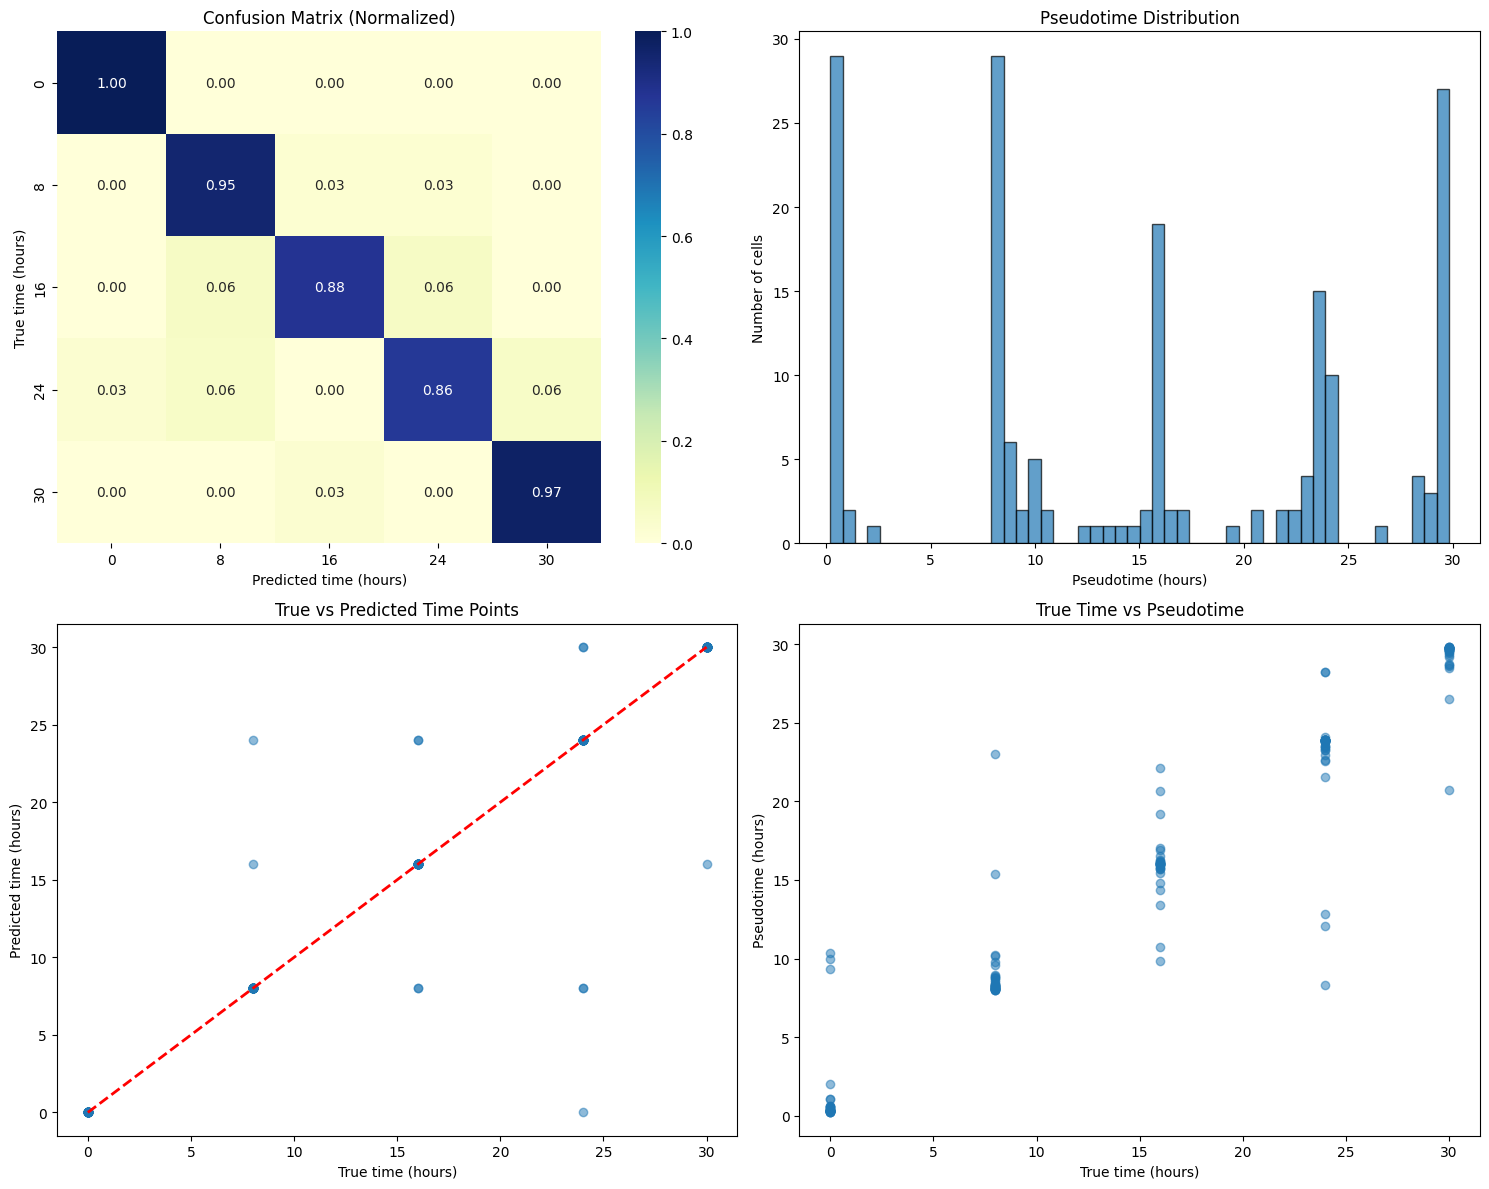

Visualization complete!


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion matrix heatmap
sns.heatmap(
    cm_xgb / cm_xgb.sum(axis=1, keepdims=True),
    annot=True,
    fmt='.2f',
    cmap='YlGnBu',
    xticklabels=label_list,
    yticklabels=label_list,
    ax=axes[0, 0]
)
axes[0, 0].set_xlabel('Predicted time (hours)')
axes[0, 0].set_ylabel('True time (hours)')
axes[0, 0].set_title('Confusion Matrix (Normalized)')

# 2. Pseudotime distribution
axes[0, 1].hist(pseudotime_xgb, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Pseudotime (hours)')
axes[0, 1].set_ylabel('Number of cells')
axes[0, 1].set_title('Pseudotime Distribution')

# 3. True vs predicted labels (in actual hours)
# Map encoded labels back to actual time
true_time_hours = pd.Series(y).map(time_dictionary).values
predicted_time_hours = pd.Series(label_predicted_xgb).map(time_dictionary).values

axes[1, 0].scatter(true_time_hours, predicted_time_hours, alpha=0.5)
axes[1, 0].plot([0, 30], [0, 30], 'r--', lw=2)
axes[1, 0].set_xlabel('True time (hours)')
axes[1, 0].set_ylabel('Predicted time (hours)')
axes[1, 0].set_title('True vs Predicted Time Points')

# 4. Pseudotime vs true time
axes[1, 1].scatter(true_time_hours, pseudotime_xgb, alpha=0.5)
axes[1, 1].set_xlabel('True time (hours)')
axes[1, 1].set_ylabel('Pseudotime (hours)')
axes[1, 1].set_title('True Time vs Pseudotime')

plt.tight_layout()
plt.show()

print("Visualization complete!")

## 8. Save Results (Optional)

You can save the results for later analysis.

In [8]:
# Uncomment to save results
# np.savetxt('results_cm.txt', cm_xgb, fmt='%i')
# np.savetxt('results_predicted_labels.txt', label_predicted_xgb, fmt='%i')
# np.savetxt('results_pseudotime.txt', pseudotime_xgb, fmt='%1.4e')
# np.savetxt('results_probabilities.txt', sceptic_prob_xgb, fmt='%1.5e')

print("Results can be saved using the code above!")

Results can be saved using the code above!


## Summary

In this notebook, we:
1. Loaded example single-cell data
2. **Mapped encoded labels to actual biological time points (0, 8, 16, 24, 30 hours)**
3. Ran Sceptic with both SVM and XGBoost
4. Examined the four types of outputs from Sceptic
5. Created basic visualizations with actual time labels

For more advanced evaluation metrics and publication-quality visualizations, see the `custom_evaluation.ipynb` notebook.